# ISR Explorations

This notebook is meant to give a starting point for exploring the calibration products used in processing Rubin images.

The data are from LSSTComCam, processed as part of Data Preview 1.

In [74]:
# Some initial imports

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')
import astropy.convolution
import numpy as np
import matplotlib.pyplot as plt

## Visualizing Flats

Many of the effects that need correction as part of ISR are apparent in the flat field images. Flat field images can make many effects more readily visible since they're an image of a uniform illumination, so you can see spatial structure that you wouldn't see from just images of stars.

We're going to use Rubin's "Butler" to get the data, and we have to do a slightly unusual trick. As part of the image processing pipelines, the Butler already knows which flat field image is the right one for any given science exposure. So to get the flat, we actually specify which science exposure we want to "correct", even though we're really going to be just looking at the flat. 

In [54]:
b = dafButler.Butler("dp1", collections=["LSSTComCam/DP1"])

Because the flat fields are basically the same for every image in DP1, it doesn't particularly matter which exposure we ask for. But we do want to look at the right filter, so I've made a table of some example exposure numbers that you can just plug in:

- u - 2024110900195
- g - 2024110800266
- r - 2024110800246
- i - 2024110800245
- z - 2024111200285
- y - 2024111900091

So to get a flat of a particular band, substitute that exposure ID into the following command. Also ComCam has 9 detectors, so you can pick detectors 0 through 8.

In [92]:
flat = b.get("flat", detector=1,
                  instrument='LSSTComCam',
                  exposure=2024110800246)

Then we're going to create a new image display tab in jupyter:


In [80]:
afw_display = afwDisplay.Display(frame=2)

And this is the command to display that image:

In [93]:
afw_display.mtv(flat)

Also note that ComCam detectors are arranged like:

|   |   |   |
| - | - | - |
| 6 | 7 | 8 |
| 3 | 4 | 5 |
| 0 | 1 | 2 |

## Exploration time

Ok, now that you have the mechanics, pick one of the bands and sensors and take a very careful look. Let's inventory all of the features you see, and then we will try to figure out as much about their origins as we can from the flat field images.

Questions to ask about each feature:
- What does its shape/position tell you?
- Is it specific to an amplifier, or a detector, or all of the detectors?
- Is it specific to one band? Or is it in all bands?
- Is it chromatic -- does it have different behavior in different bands?
- Does it affect photons or electrons?
- Where in the signal chain (from photons to counts in the image) does it get introduced?
- Is the flat really the right way to correct it?

Some effects you might notice by-eye, but you get better clarity by plotting them in some physical space. That could be either
- versus detector coordinates, if you think it's something happening in the detector
- versus focal plane coordinates, if it's something optical



A few other hints for reference: if you want to look at the actual "science" image for comparison, you can get that with:

In [97]:

visit_image = b.get("visit_image", detector=1, 
                  instrument='LSSTComCam',
                  visit=2024110800246)

In [98]:
afw_display.mtv(visit_image)

You can also get the raw image by asking for `raw`.

Also sometimes the noise introduces Moiré patterns that can make it hard to visualize some larger scale effects. A convenient way to see fainter structures is to smooth the image a little bit before displaying it. Astropy can do this, with:

In [ ]:

flat_smoothed = astropy.convolution.convolve(flat.image.array, astropy.convolution.Gaussian2DKernel(2))


To visualize it back in the firefly viewer, you'll need to put the convolved results "back" in the flat. But note that this now erases the original flat field image, so if you want to see it again you'll have to go ask the butler for it again.

In [48]:
# Commenting this out just so you don't accidentally overwrite the image. Uncomment the next lines to view the convolved image in firefly.
# flat.image.array = flat_smoothed
#afw_display.mtv(flat)

# Detector Gain

**Consider this optional! Spending time on the flats is more important**


## Photon Transfer Curve


The "Photon Transfer Curve" is the name given to the relationship between the signal level and the noise level in a sensor. We're going to do a few experiments to show how it works in principle, and then we'll look at some real images and make some diagnostic measurements.


First we need a model of the noise in CCD image. I'm going to give this to you so we all start out on the same page


In [82]:
def simulated_image(signal_level, read_noise, gain):
    """
    Return a 1-D simulated "image" with the noise properties of
    a CCD sensor. The image is always 1000 pixels long.
    
    signal_level is the mean number of electrons in each pixel.
    read_noise is the noise of the readout amplifier, in electrons.
    gain is the number of electrons per ADU.
    
    """
    return (1/gain) * (read_noise*np.random.randn(1000) +  np.random.poisson(signal_level, size=1000))

Before diving in to programming, take a careful look at the components in the simulated image. What are the two noise sources, and why do they have that functional form? We're going to be looking a lot at the image "gain"; does it make sense how that is applied?

Let's make some simulations. What we want to do is loop over a set of input levels light levels, from zero to "full well" capacity (on order of 10,000 electrons). For each simulated image, we want to measure the mean signal level (because that's what we see as users of a CCD) and the standard deviation of that image. Save those in two lists, but at the end convert those back to numpy arrays to make downstream usage easier.

For right now, set the read noise to 5, and the gain to 0.8.

In [83]:
# Answer
noise_levels = []
measured_signal_levels = []
input_signal_levels = np.logspace(0, 4, 30)

for input_signal_level in input_signal_levels:
    image = simulated_image(input_signal_level, 5, 0.8)
    noise_levels.append(np.std(image))
    measured_signal_levels.append(np.mean(image))

noise_levels = np.array(noise_levels)
measured_signal_levels = np.array(measured_signal_levels)

Plot the noise vs. the measured signal level, on a log-log plot.

What is the behavior you see? What are the two different noise regimes?

Fit a straight line to the "bright" portion of the data (high signal levels) and print the resulting coefficients. Remember that you're looking at a log-log plot, and so you want to fit the logs of the variables. You can add this to the plot in the cell above.

Why does the line have that value of the slope?

[0.47288634 0.1447549 ]


Text(0.5, 0, 'Measured Signal Level')

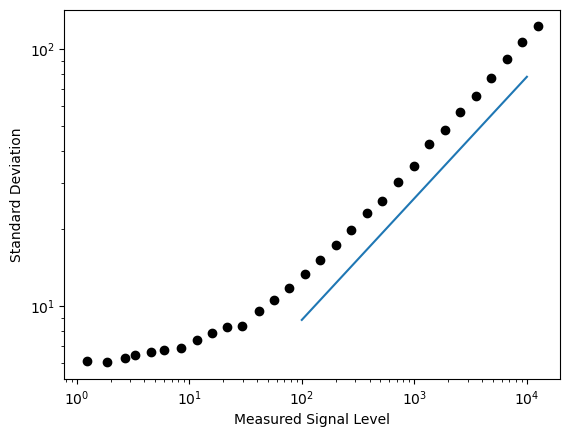

In [84]:
# Answer
high_counts, = np.where(measured_signal_levels > 100)
fit = np.polyfit(np.log10(measured_signal_levels[high_counts]), np.log10(noise_levels[high_counts]), 1)
print(fit)
x = np.logspace(2, 4, 10)
plt.loglog(measured_signal_levels, noise_levels, 'ko')
plt.plot(x, 10**(fit[0]*np.log10(x) ), '-')
plt.ylabel("Standard Deviation")
plt.xlabel("Measured Signal Level")

Now we're going to plot something slightly different. Plot the *variance* this time, and on a linear plot instead of log-log (again vs. measured signal level). Fit a straight line to the data (in linear space) and print the coefficients. Also print the *reciprocal* of the slope.

Where did this slope come from? 

[0.82016243 0.01775465]


Text(0.5, 0, 'Measured Signal Level')

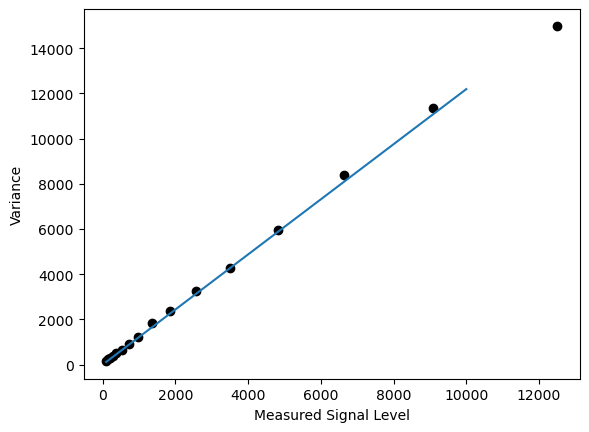

In [85]:
# Answer
high_counts, = np.where(measured_signal_levels > 100)

plt.plot(measured_signal_levels[high_counts], (noise_levels[high_counts])**2, 'ko')
fit = np.polyfit(measured_signal_levels, noise_levels**2, 1)
print(1/fit)

plt.plot(x, fit[0] * x, '-')
plt.ylabel("Variance")
plt.xlabel("Measured Signal Level")

The slope here is related to the gain (either proportionally or inversely, depending on how one chooses to define gain). This can be summarized as

$$ \frac{1}{\textrm{gain}} =  \langle \frac{\textrm{Variance}}{\textrm{Mean Signal Level}} \rangle $$

It's a clever and useful trick, or at least it seems like a trick, because the standard deviation plot wasn't affected by the gain at all. Go back and try varying the gain and re-run the plots, and you'll see what does and doesn't change.

One way to think of it is that the measured signal level is affected linearly by the gain, but the variance is affected by the square of the gain. Dividing these two gives you a linear relation back, but when dividing the square root of the variance, the gain cancels out.
